In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import sys
import itertools
import numpy as np
import tqdm
import multiprocessing as mp
from itertools import groupby
from collections import Counter
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
sys.path.append("../")

In [4]:
from utils import helper

# Best base learner decider

First step is to decide which base learning algorithm is suited to this problem. We train all the base learners in the ensemble using each of the three learning algorithms, SVM, NN and GBC and record their performance using the evaluation scheme discussed in the paper.

In [5]:
# Sequence and label files 
enz_file = '../data/seq/train_enzyme_sequence.csv'
label_file = '../data/label/train_enzyme_labels.csv'

# Feature dir for iFeature,kernel,pssm 
ifeatdatadir = '../data/features/ifeature/featvec/train/'
kerneldatadir = '../data/features/kernel/featvec/train/'
pssmdatadir = '../data/features/possum/featvec/train/'

trainfeatdirs = [ifeatdatadir,kerneldatadir,pssmdatadir]

Num_sim = 10000

In [6]:
def check_performance(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, k, opt, N):
    pool = mp.Pool(mp.cpu_count())
    
    iter_svm = zip([enz_file for _ in range(N)],
                   [test_enz_file for _ in range(N)],
                   [label_file for _ in range(N)],
                   [train_feat_dirs for _ in range(N)],
                   [test_feat_dirs for _ in range(N)],
                   [hyper_param_file for _ in range(N)],
                   [base_algo for _ in range(N)],
                   [k for _ in range(N)],
                   [opt for _ in range(N)],
                   range(N))
    
    metrics = pool.starmap(helper.check_base_performance,iter_svm)
    
    precision = [m[0] for m in metrics]
    recall = [m[1] for m in metrics]
    accuracy = [m[2] for m in metrics]
    
    return round(np.mean(precision), 2), round(np.mean(recall), 2), round(np.mean(accuracy), 2)

In [7]:
%%time
check_performance(enz_file, None, label_file, trainfeatdirs, None, None, 'SVM', 5, False, Num_sim)

CPU times: user 540 ms, sys: 215 ms, total: 755 ms
Wall time: 1h 27min 21s


(0.88, 0.88, 0.8)

In [8]:
%%time
check_performance(enz_file, None, label_file, trainfeatdirs, None, None, 'NN', 5, False, Num_sim)

CPU times: user 673 ms, sys: 257 ms, total: 930 ms
Wall time: 1h 47min 42s


(0.82, 0.94, 0.8)

In [9]:
%%time
check_performance(enz_file, None, label_file, trainfeatdirs, None, None, 'GBC', 5, False, Num_sim)

CPU times: user 435 ms, sys: 188 ms, total: 623 ms
Wall time: 1h 36min 46s


(0.82, 0.92, 0.79)

# Individual Hyperparameter Optimization

After selecting the base learning algorithm selection, we hyperparameter optimize each base learner to get optimal results from the ensemble model. 

The steps are as follows:

1. select base learner and simulate model with the optimize flag activated.
2. train the ensemble and record the best hyperparameters learnt for each base model. 
3. run it 1000 times and record the hyperparameters for each base learner throughout the simulations.
4. store the most frequent hyperparameters across the 1000 simulations for each base learner. 

In [10]:
def most_frequent(arr):
    count = Counter(arr)
    most_freq = count.most_common(1)[0][0]
    return most_freq


def store_best_hps(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, k, opt, N):
    pool = mp.Pool(mp.cpu_count())
    
    iter_func = zip([enz_file for _ in range(N)],
               [test_enz_file for _ in range(N)],
               [label_file for _ in range(N)],
               [train_feat_dirs for _ in range(N)],
               [test_feat_dirs for _ in range(N)],
               [hyper_param_file for _ in range(N)],
               [base_algo for _ in range(N)],
               [k for _ in range(N)],
               [opt for _ in range(N)],
               range(N))
    
    all_hps = sum(list(pool.starmap(helper.best_hps, iter_func)),[])
    all_hps = sorted(all_hps, key=lambda x: x[0])

    with open('../data/results/hpopt/IndHPOpt.csv','w') as f:
        f.write('feat_name,regC,kernel,pca_comp')
        f.write('\n')
        for feat_name, feat_info in groupby(all_hps, key=lambda x: x[0]):
            best_hp_list = [hp[1] for hp in list(feat_info)]
            best_regC = most_frequent([x[0] for x in best_hp_list])
            best_kernel = most_frequent([x[1] for x in best_hp_list])
            best_ncomp = most_frequent([x[2] for x in best_hp_list])
            f.write(f"{feat_name},{best_regC},{best_kernel},{best_ncomp}")
            f.write('\n')

    return 

In [11]:
%%time 
store_best_hps(enz_file, None, label_file, trainfeatdirs, None, None, 'SVM', 5, True, Num_sim//10)

CPU times: user 1.69 s, sys: 791 ms, total: 2.48 s
Wall time: 9h 23min 30s


# Feature extraction technique performance

Comparing the performance of individual feature extraction techniques.

After getting the best set of hyperparameters, change the model such that it can accept the individual hyperparameter file. 

In [12]:
indhpoptfile = '../data/results/hpopt/IndHPOpt.csv'


def indfeat_measure(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, k, opt, N):
    pool = mp.Pool(mp.cpu_count())
    
    iter_func = zip([enz_file for _ in range(N)],
               [test_enz_file for _ in range(N)],
               [label_file for _ in range(N)],
               [train_feat_dirs for _ in range(N)],
               [test_feat_dirs for _ in range(N)],
               [hyper_param_file for _ in range(N)],
               [base_algo for _ in range(N)],
               [k for _ in range(N)],
               [opt for _ in range(N)],
               range(N))
    
    all_metrics = sum(list(pool.starmap(helper.indfeat_performance, iter_func)), [])
    all_metrics = sorted(all_metrics, key=lambda x: x[0])
    with open("../data/results/indfeatreport.csv", 'w') as f:
        f.write('featname,min_precision,max_precision,mean_precision,std_precision,min_recall,max_recall,mean_recall,std_recall,min_accuracy,max_accuracy,mean_accuracy,std_accuracy')
        f.write('\n')
        for featname, featinfo in groupby(all_metrics, key=lambda x:x[0]):
            all_metric_list = [met[1] for met in featinfo]
            all_prec = [m[0] for m in all_metric_list]
            all_rec = [m[1] for m in all_metric_list]
            all_acc = [m[2] for m in all_metric_list]

            min_prec = round(min(all_prec),2)
            max_prec = round(max(all_prec),2)
            mean_prec = round(np.mean(all_prec),2)
            std_prec = round(np.std(all_prec),2)

            min_rec = round(min(all_rec),2)
            max_rec = round(max(all_rec),2)
            mean_rec = round(np.mean(all_rec),2)
            std_rec = round(np.std(all_rec),2)

            min_acc = round(min(all_acc),2)
            max_acc = round(max(all_acc),2)
            mean_acc = round(np.mean(all_acc),2)
            std_acc = round(np.std(all_acc),2)
            
            f.write(f'{featname},{min_prec},{max_prec},{mean_prec},{std_prec},{min_rec},{max_rec},{mean_rec},{std_rec},{min_acc},{max_acc},{mean_acc},{std_acc}')
            f.write('\n')

        
    return
        

In [13]:
%%time
indfeat_measure(enz_file, None, label_file, trainfeatdirs, None, indhpoptfile, 'SVM', 5, False, Num_sim)

CPU times: user 33 s, sys: 4 s, total: 37 s
Wall time: 1h 22min 36s


# Parametric sweep of ensemble model hyperparameter k

With the individualized hyperparameters, its time to check the ensemble performance. We run a paramteric sweep of the ensemble model parameter k to get the best estimate of the parameter which denotes the number of base models to select in the ensemble. 

In [14]:
def ensemble_param_sweep(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, ks, opt, N):

    _iter = list(itertools.product(ks, range(N)))
    iter_func = zip([enz_file for _ in range(len(_iter))],
           [test_enz_file for _ in range(len(_iter))],
           [label_file for _ in range(len(_iter))],
           [train_feat_dirs for _ in range(len(_iter))],
           [test_feat_dirs for _ in range(len(_iter))],
           [hyper_param_file for _ in range(len(_iter))],
           [base_algo for _ in range(len(_iter))],
           [k[0] for k in _iter],
           [opt for _ in _iter],
           [rs[1] for rs in _iter])
    
    pool = mp.Pool(mp.cpu_count())
    all_preds = list(pool.starmap(helper.ensemble_pred, iter_func))
    all_metrics = list(map(helper.get_metrics, all_preds))
    def get_mean(met):
        return round(np.mean(met), 2)
    
    with open('../data/results/en_param_sweep.csv','w') as f:
        f.write('model_k,mean_precision,mean_recall,mean_accuracy')
        f.write('\n')
        for model_k, model_info in itertools.groupby(zip(list(_iter), all_metrics), key=lambda x:x[0][0]):
            model_metrics = [m[1] for m in list(model_info)]
            prec = [m[0] for m in model_metrics]
            rec = [m[1] for m in model_metrics]
            acc = [m[2] for m in model_metrics]    
        
            f.write(f"{model_k},{','.join(list(map(str,(list(map(get_mean,[prec,rec,acc]))))))}")
            f.write('\n')
        
    return 

In [15]:
%%time
ensemble_param_sweep(enz_file, None, label_file, trainfeatdirs, None, indhpoptfile, 'SVM', [5,9,15,21,31], False, Num_sim)

CPU times: user 1min 24s, sys: 560 ms, total: 1min 24s
Wall time: 6h 49min 16s


# Ensemble model performance

With the best base learning algorithm, the best sets of base learner hyperparameters, and the 5 top ranked feature extraction techniques, check the ensemble model performance 

## Ensemble model parameter k=5 provides the best performance. Hence 5-base learners will be used in the ensemble.

In [16]:
pd.read_csv('../data/results/en_param_sweep.csv')

,model_k,mean_precision,mean_recall,mean_accuracy
0,5,0.87,0.89,0.80
1,9,0.87,0.88,0.79
2,15,0.87,0.87,0.79
3,21,0.86,0.87,0.78
4,31,0.85,0.87,0.78


In [17]:
def ensemble_eval(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, k, opt, N):

    pool = mp.Pool(mp.cpu_count())
    
    iter_func = zip([enz_file for _ in range(N)],
               [test_enz_file for _ in range(N)],
               [label_file for _ in range(N)],
               [train_feat_dirs for _ in range(N)],
               [test_feat_dirs for _ in range(N)],
               [hyper_param_file for _ in range(N)],
               [base_algo for _ in range(N)],
               [k for _ in range(N)],
               [opt for _ in range(N)],
               range(N))
    
    all_preds = list(pool.starmap(helper.ensemble_pred, iter_func))
    model_metrics = list(map(helper.get_metrics, all_preds))
    all_prec = [m[0] for m in model_metrics]
    all_rec = [m[1] for m in model_metrics]
    all_acc = [m[2] for m in model_metrics]
    
    min_prec = round(min(all_prec),2)
    max_prec = round(max(all_prec),2)
    mean_prec = round(np.mean(all_prec),2)
    std_prec = round(np.std(all_prec),2)

    min_rec = round(min(all_rec),2)
    max_rec = round(max(all_rec),2)
    mean_rec = round(np.mean(all_rec),2)
    std_rec = round(np.std(all_rec),2)

    min_acc = round(min(all_acc),2)
    max_acc = round(max(all_acc),2)
    mean_acc = round(np.mean(all_acc),2)
    std_acc = round(np.std(all_acc),2)
    
    with open('../data/results/ensemble_results.csv','w') as f:
        f.write('ensemble,min_precision,max_precision,mean_precision,std_precision,min_recall,max_recall,mean_recall,std_recall,min_accuracy,max_accuracy,mean_accuracy,std_accuracy')
        f.write('\n')
    
        f.write(f'ensemble,{min_prec},{max_prec},{mean_prec},{std_prec},{min_rec},{max_rec},{mean_rec},{std_rec},{min_acc},{max_acc},{mean_acc},{std_acc}')
        f.write('\n')
        
    return

In [18]:
%%time
ensemble_eval(enz_file, None, label_file, trainfeatdirs, None, indhpoptfile, 'SVM', 5, False, Num_sim)

CPU times: user 17.3 s, sys: 0 ns, total: 17.3 s
Wall time: 1h 22min 13s


## Store model results to disk

In [19]:
def ensemble_store(enz_file, test_enz_file, label_file, train_feat_dirs, test_feat_dirs, hyper_param_file, base_algo, k, opt, N):
    """function stores the validation data in first line and prediction data in second line"""
    pool = mp.Pool(mp.cpu_count())
    
    iter_func = zip([enz_file for _ in range(N)],
           [test_enz_file for _ in range(N)],
           [label_file for _ in range(N)],
           [train_feat_dirs for _ in range(N)],
           [test_feat_dirs for _ in range(N)],
           [hyper_param_file for _ in range(N)],
           [base_algo for _ in range(N)],
           [k for _ in range(N)],
           [opt for _ in range(N)],
           range(N))

    all_preds = list(pool.starmap(helper.ensemble_pred, iter_func))
    
    with open("../data/results/ensemble_preds.csv","w") as f:
        for rs_pred in all_preds:
            f.write(",".join(map(str,rs_pred[0])))
            f.write("\n")
            f.write(",".join(map(str,rs_pred[1])))
            f.write("\n")
    return

In [20]:
%%time
ensemble_store(enz_file, None, label_file, trainfeatdirs, None, indhpoptfile, 'SVM', 5, False, Num_sim)

CPU times: user 1.09 s, sys: 71.8 ms, total: 1.17 s
Wall time: 1h 21min 49s


## Model Evaluation all three categories 

In [21]:
model_pred_file = '../data/results/ensemble_preds.csv'

def read_pred_file(filename):
    stream = open(filename)
    value = stream.readlines()
    valid = [list(map(float,value[i].strip().split(','))) for i in range(0,len(value),2)]
    preds = [list(map(float,value[i].strip().split(','))) for i in range(1,len(value),2)]
    return zip(valid, preds)
    

In [22]:
preds = list(read_pred_file(model_pred_file))

In [23]:
label2_metrics = list(map(helper.get_metrics_lab2,preds))
label2_prec = [p[0] for p in label2_metrics]
label2_rec = [p[1] for p in label2_metrics]

label1_metrics = list(map(helper.get_metrics_lab1,preds))
label1_prec = [p[0] for p in label1_metrics]
label1_rec = [p[1] for p in label1_metrics]

label3_metrics = list(map(helper.get_metrics,preds))
label3_prec = [p[0] for p in label3_metrics]
label3_rec = [p[1] for p in label3_metrics]

In [24]:
list(map(np.mean,[label1_prec, label1_rec, label2_prec, label2_rec, label3_prec, label3_rec]))

[0.779487, 0.922682, 0.542631, 0.280402, 0.867086, 0.889373]

## Model evaluation label 3 or medium chained category

In [25]:
label3_acc = [p[2] for p in label3_metrics]

In [26]:
def get_ind_metrics(metric):
    return np.mean(metric), np.median(metric), min(metric)

In [27]:
get_ind_metrics(label3_acc), get_ind_metrics(label3_prec)

((0.799162, 0.79, 0.55), (0.867086, 0.87, 0.36))

In [28]:
import matplotlib.pyplot as plt

In [29]:
def plot_histogram(metrics, metric_names, cs=['midnightblue','teal'], model='Ensemble'):
    fig,ax = plt.subplots(1,2, figsize=(12,4))
    for i in range(len(metrics)):
        ax[i].hist(metrics[i], bins=10, color=cs[i])
        ax[i].set_xlim(min(metrics[i]), max(metrics[i]))
        ax[i].set_xlabel(f'{metric_names[i]} scores')
        ax[i].set_title(f'{metric_names[i]} Score Distribution of {model} Model')
    
    fig.text(0.0001, 0.5, 'Counts', va='center', rotation='vertical')
    plt.tight_layout()
    plt.savefig(f'../data/results/figures/{model}_dist.png')
    return


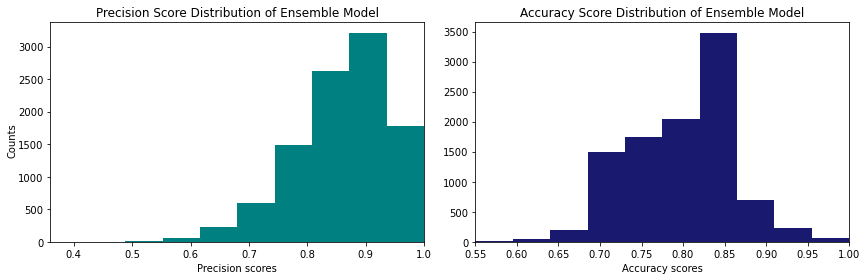

In [30]:
plot_histogram([label3_prec,label3_acc], ['Precision','Accuracy'], ['teal', 'midnightblue'])